### Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, we'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

More about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

##### Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start by importing our usual resources. And checking if we can train our model on GPU.

##### Download Data

Download the flower data from [this link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/September/5baa60a0_flower-photos/flower-photos.zip), save it in the home directory of this notebook and extract the zip file to get the directory `flower_photos/`. **Make sure the directory has this exact name for accessing data: flower_photos**.

In [1]:
#Import Libraries
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


##### Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes it very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [3]:
#Define training and test data directories
data_dir='flower_photos/'
train_dir=os.path.join(data_dir,'train/')
test_dir=os.path.join(data_dir,'test/')

#Classes are folders in each directory with these names
classes=['daisy','dandelion','roses','sunflowers','tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [4]:
#Load and transform data using ImageFolder
#VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform=transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])

train_data=datasets.ImageFolder(train_dir,transform=data_transform)
test_data=datasets.ImageFolder(test_dir,transform=data_transform)

#Print out some data stats
print('Num training images: ',len(train_data))
print('Num test images: ',len(test_data))

Num training images:  3130
Num test images:  540


##### DataLoaders and Data Visualization

In [5]:
#Define dataloader parameters
batch_size=20
num_workers=0

#Prepare data loaders
train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers,shuffle=True)

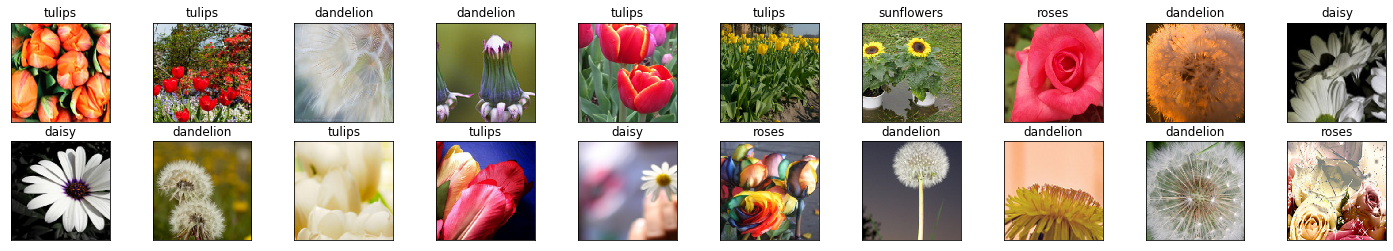

In [6]:
#Visualize some sample data

#Obtain one batch of training images
dataiter=iter(train_loader)
images,labels=dataiter.next()
images=images.numpy() # convert images to numpy for display

#Plot the images in the batch, along with the corresponding labels
fig=plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1, 2, 0)))
    ax.set_title(classes[labels[idx]])

##### Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [7]:
#Load the pretrained model from pytorch
vgg16=models.vgg16(pretrained=True)

#Print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features)

4096
1000


In [9]:
#Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad=False

##### Final Classifier Layer

Once we have the pre-trained feature extractor, we just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

We can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

In [10]:
import torch.nn as nn

n_inputs=vgg16.classifier[6].in_features

#Add last linear layer (n_inputs -> 5 flower classes)
#New layers automatically have requires_grad = True
last_layer=nn.Linear(n_inputs,len(classes))

vgg16.classifier[6]=last_layer

#If GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

#Check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)
#print(vgg16)

5


##### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [11]:
import torch.optim as optim

#Specify loss function (categorical cross-entropy)
criterion=nn.CrossEntropyLoss()

#Specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer=optim.SGD(vgg16.classifier.parameters(),lr=0.001)

##### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [12]:
#Number of epochs to train the model
n_epochs=2

for epoch in range(1,n_epochs+1):

    #Keep track of training and validation loss
    train_loss=0.0

    #Train the model
    #Model by default is set to train
    for batch_i,(data, target) in enumerate(train_loader):
        #Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data,target=data.cuda(),target.cuda()
        #Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output=vgg16(data)
        #Calculate the batch loss
        loss=criterion(output, target)
        #Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #Perform a single optimization step (parameter update)
        optimizer.step()
        #Update training loss 
        train_loss+=loss.item()
        
        if batch_i % 20 == 19:    #Print training loss every specified number of mini-batches
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, train_loss / 20))
            train_loss = 0.0

Epoch 1, Batch 20 loss: 1.4910136342048645
Epoch 1, Batch 40 loss: 1.3403725266456603
Epoch 1, Batch 60 loss: 1.2179507076740266
Epoch 1, Batch 80 loss: 1.1443448483943939
Epoch 1, Batch 100 loss: 1.0572950541973114
Epoch 1, Batch 120 loss: 0.9955650925636291
Epoch 1, Batch 140 loss: 0.9668570131063461
Epoch 2, Batch 20 loss: 0.8637304425239563
Epoch 2, Batch 40 loss: 0.8097963303327560
Epoch 2, Batch 60 loss: 0.8664056211709976
Epoch 2, Batch 80 loss: 0.8112871289253235
Epoch 2, Batch 100 loss: 0.8001510560512543
Epoch 2, Batch 120 loss: 0.7920250773429871
Epoch 2, Batch 140 loss: 0.7869456648826599


##### Testing

Below the test accuracy for each flower class.

In [15]:
#Track test loss 
#Over 5 flower classes
test_loss=0.0
class_correct=list(0. for i in range(5))
class_total=list(0. for i in range(5))

vgg16.eval() #Eval mode

#Iterate over test data
for data,target in test_loader:
    #Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target=data.cuda(),target.cuda()
    #Forward pass: compute predicted outputs by passing inputs to the model
    output=vgg16(data)
    #Calculate the batch loss
    loss=criterion(output,target)
    #Update  test loss 
    test_loss+=loss.item()*data.size(0)
    #Convert output probabilities to predicted class
    _, pred=torch.max(output,1)    
    #Compare predictions to true label
    correct_tensor=pred.eq(target.data.view_as(pred))
    correct=np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    #Calculate test accuracy for each object class
    for i in range(batch_size):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1

#Calculate avg test loss
test_loss=test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.748890

Test Accuracy of daisy: 80% (74/92)
Test Accuracy of dandelion: 89% (118/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 77% (78/101)
Test Accuracy of tulips: 54% (68/124)

Test Accuracy (Overall): 73% (399/540)


##### Visualize Sample Test Results

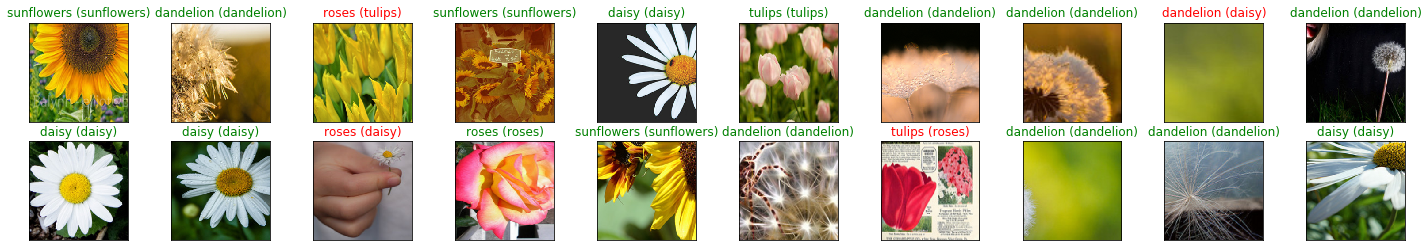

In [16]:
#Obtain one batch of test images
dataiter=iter(test_loader)
images,labels=dataiter.next()
images.numpy()

#Move model inputs to cuda, if GPU available
if train_on_gpu:
    images=images.cuda()

#Get sample outputs
output=vgg16(images)
#Convert output probabilities to predicted class
_, preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

#Plot the images in the batch, along with predicted and true labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)))
    ax.set_title("{} ({})".format(classes[preds[idx]],classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))